In [1]:
from google.colab import drive

PATH = "/content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw"
drive.mount('/content/drive')


Mounted at /content/drive


In [69]:
import os
import pandas as pd
import numpy as np

data_path = os.path.join(PATH, "storeleads-scraping-about_data_toclean.dta")
#df = pd.read_csv(data_path)
df = pd.read_stata(data_path)



# add empty row called clean text
df['clean_text'] = ''
df.dropna(inplace=True)
df['text'] = df['text'].apply(str.strip)

print(len(df))

display(df.head())


636812


,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text
0,homegoodsboutique.com,homegoodsboutique.com/pages/about-us,US,en,shopify,About Us Buy More/Save More Sale - Up to 30% O...,2,No dup,206,
1,flexam.fr,flexam.fr/pages/about-flex-am-is-a-company,US,en,shopify,About FLEX AM is a company Have an account? Lo...,3,No dup,206,
2,hevenlyhomegoods.com,hevenlyhomegoods.com/pages/about-us,US,en,shopify,About Us Buy More/Save More Sale - Up to 30% O...,2,No dup,206,
3,fruitsfordrinks.com,fruitsfordrinks.com/pages/about,US,en,shopify,"Why Fruits for Drinks? Consistent, Efficient a...",0,No dup,206,
4,landecandleco.com,landecandleco.com/pages/about-us,US,en,shopify,About Us Hand Poured with love for Pets! 🐾 Use...,0,No dup,206,


In [3]:
! pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.5 MB/s eta 0:00:00


In [75]:
import tiktoken

encoder = tiktoken.get_encoding("gpt2")  # older GPT-2 style
df['num_tokens'] = df['text'].apply(lambda x: len(encoder.encode(x)))
df.head()

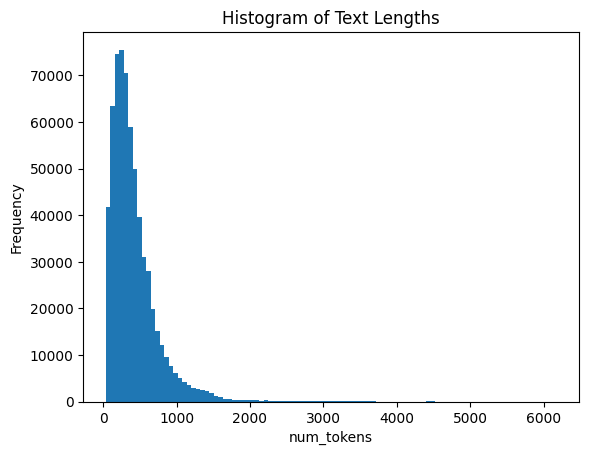

In [74]:
create_histogram(df, "num_tokens")

In [8]:
# from utils import trim

# df = trim(df, "num_tokens", [100,1500])

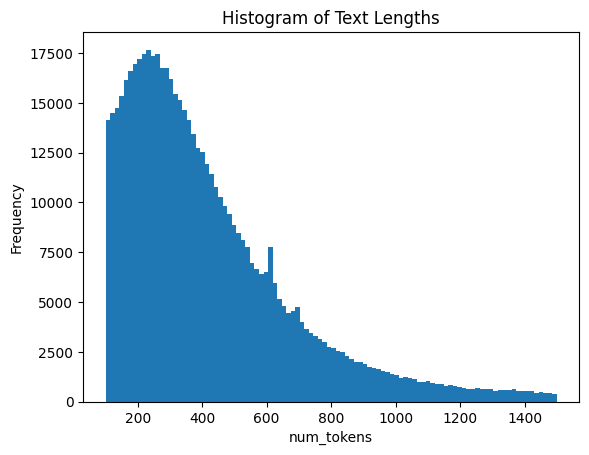

In [9]:
create_histogram(df, "num_tokens")

In [76]:
import pandas as pd

# Example: assume df has columns ["id", "text", "num_tokens"]
df_sorted = df.sort_values(by="num_tokens").copy()

# We'll store the original index so we can map back later,
# or you can just use "df['id']" if it is guaranteed unique.
df_sorted["orig_index"] = df_sorted.index

# Reset the DataFrame index so we can easily chunk it
df_sorted.reset_index(drop=True, inplace=True)


In [77]:
print(len(df_sorted))
display(df_sorted.head())

636812


,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text,num_tokens,orig_index
0,aoi.deltaembroidery.com,aoi.deltaembroidery.com/pages/about-us,US,en,shopify,Contact Us If you are experiencing issues plea...,0,No dup,206,,34,229
1,next-extracts.com,next-extracts.com/pages/about-us,US,en,shopify,"At Next we are a culture of love, passion and ...",2,No dup,207,,35,290
2,iamthetee.com,iamthetee.com/pages/about-us,IN,en,shopify,About Us INFO SERVICES About UsWe are passiona...,0,No dup,207,,35,336
3,novelbookstore.co,novelbookstore.co/pages/about-novel,PT,en,shopify,Cart Congratulations! Your order qualifies for...,4,No dup,211,,35,1369
4,unsulliedbody.com,unsulliedbody.com/pages/about-us,US,en,shopify,About Us Free Domestic Shipping To help people...,1,No dup,211,,35,1290


# Preparing Batch File
Batches start with a .jsonl file where each line contains the details of an individual request t

````json
{"custom_id": "request-1",
 "method": "POST", "url": "/v1/chat/completions",
 "body": {
     "model": "gpt-3.5-turbo-0125",
     "messages": [
    {
      "role": "system",
      "content": "You are a highly precise and reliable assistant. Your task is to extract and retain only the core 'About Us' content from the provided scraped text. Remove any extraneous elements such as headings, promotions, or button text that may appear at the beginning or end. If no clear 'About Us' section exists, return an empty response rather than generating one. If the text is not in English, translate it into English. Output only the cleaned and, if necessary, translated 'About Us' content, with no additional comments or formatting."
    },
    {
      "role": "user",
      "content": "PASTE_SCRAPED_TEXT_HERE"
    }
  ],
     "max_tokens": 1000}}
````

In [86]:
from utils import create_batch_requests
create_batch_requests(df_sorted,BATCH_SIZE=50000, path=PATH)

Batch 1/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_1.jsonl
Batch 2/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_2.jsonl
Batch 3/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_3.jsonl
Batch 4/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_4.jsonl
Batch 5/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_5.jsonl
Batch 6/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_6.jsonl
Batch 7/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_7.jsonl
Batch 8/13 saved: /content/drive/MyDrive/MSc /Narratives Project Nadav/analysis/data/raw/batch_requests/batch_8.jsonl
Batch 9/13 saved: /content/drive/MyDrive/MSc /Narratives

In [19]:
display(df_sorted.head())
# print text example
print(df_sorted.iloc[30]['text'])

,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text,num_tokens,orig_index
0,nazeerah.com,nazeerah.com/pages/about-us,US,en,shopify,Congratulations! Your order qualifies for free...,14,No dup,472,,101,57813
1,terryleemosley.com,terryleemosley.com/pages/about-us,US,en,shopify,About Us Our logo represents more than just th...,1,No dup,451,,101,53209
2,pairedhosiery.ca,pairedhosiery.ca/pages/about-us,US,en,shopify,About Us Fully stocked with many popular brand...,0,No dup,385,,101,38969
3,thestopmotionbox.com,thestopmotionbox.com/pages/about-tsmb-team,US,en,shopify,It integrates online learning with hands-on an...,4,No dup,555,,101,77073
4,wixandwax.co.uk,wixandwax.co.uk/pages/about-us,GB,en,shopify,About Us Loading... £0.00 GBP FREE shipping on...,1,No dup,466,,101,56686


About us Your Cart is EmptyWe have collaborated with all renowned brands and have been successful at it. This along with continuous support and demand from our customers has further encouraged us to take the next leap and expand our business.About usContact usSize ChartRefund & ExchangeShipping PolicyWith the passage of time, owing to our dedicated services, our business witnessed a surge in the number of loyal customers who proudly have made us what we are today. © 2024 Brands Galleria. Powered by Winkplan.com


In [87]:
import json

# Specify the JSONL file to check
jsonl_file = "batch_requests/batch_1.jsonl"  # Adjust the path if needed

# Read the first line (first request) from the JSONL file
with open(jsonl_file, "r", encoding="utf-8") as f:
    first_request = f.readline().strip()  # Read the first line and remove extra spaces

# Convert it to a dictionary and pretty print
if first_request:
    request_data = json.loads(first_request)
    print(json.dumps(request_data, indent=4, ensure_ascii=False))  # Pretty print JSON
else:
    print("Error: The JSONL file is empty or not formatted correctly.")


{
    "custom_id": "request-229",
    "method": "POST",
    "url": "/v1/chat/completions",
    "body": {
        "model": "gpt-4o-mini",
        "messages": [
            {
                "role": "system",
                "content": "You are a highly precise and reliable assistant. Your task is to extract and retain only the core 'About Us' content from the provided scraped text. Remove any extraneous elements such as headings, promotions, or button text that may appear at the beginning or end. If no clear 'About Us' section exists, return an empty response rather than generating one. do not add anything that did not exist in the text before. If the text is not in English, translate it into English. Output only the cleaned and, if necessary, translated 'About Us' content, with no additional comments or formatting."
            },
            {
                "role": "user",
                "content": "Contact Us If you are experiencing issues please refresh the page Welcome Auto Owne

# upload the .jsonl Batch file

In [91]:
from openai import OpenAI
from my_secrets import OPENAI_API_KEY
client = OpenAI(api_key=OPENAI_API_KEY)

batch_input_file = client.files.create(
    file=open("batch_requests/batch_1.jsonl","rb"),
    purpose="batch"
)

print(batch_input_file)

FileObject(id='file-Pafrm3TP62zJrf3g3YGwZp', bytes=57051568, created_at=1741190651, filename='batch_1.jsonl', object='file', purpose='batch', status='processed', status_details=None, expires_at=None)


In [89]:
files = client.files.list()
print(files)

SyncCursorPage[FileObject](data=[FileObject(id='file-Hh8MCiotCqCcZP5ku6MavW', bytes=1048696, created_at=1741128489, filename='batch_67c6ea544f5c8190b79c5bd59a922006_output.jsonl', object='file', purpose='batch_output', status='processed', status_details=None, expires_at=1743720489), FileObject(id='file-MVGSApwhrf2tWp5dYiXQFC', bytes=1184779, created_at=1741089342, filename='batch_1.jsonl', object='file', purpose='batch', status='processed', status_details=None, expires_at=1743681342), FileObject(id='file-HT7YKjQZyhKXT9AYh4nx9b', bytes=390890, created_at=1741029505, filename='batch_67c5c31d4a4c8190a42f7e6e4005e1ca_error.jsonl', object='file', purpose='batch_output', status='processed', status_details=None, expires_at=1743621505), FileObject(id='file-HThh66mAwWi8jS5a4MW1c6', bytes=960722, created_at=1741013752, filename='batch_1.jsonl', object='file', purpose='batch', status='processed', status_details=None, expires_at=1743605752), FileObject(id='file-BmjrBqt2rcbNtgtmmuVwWU', bytes=57667

# Creating the Batch
Once you've successfully uploaded your input file, you can use the input File object's ID to create a batch. In this case, let's assume the file ID is file-abc123. For now, the completion window can only be set to 24h. You can also provide custom metadata via an optional metadata parameter.

In [90]:
!wc -l batch_requests/batch_1.jsonl

50000 batch_requests/batch_1.jsonl


In [92]:
current_batch = client.batches.create(
    input_file_id=batch_input_file.id,  # or whatever your variable name is
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={
        "description": "nightly eval job"
    }
)

this should be the output:
```python
{
  "id": "batch_abc123",
  "object": "batch",
  "endpoint": "/v1/chat/completions",
  "errors": null,
  "input_file_id": "file-abc123",
  "completion_window": "24h",
  "status": "validating",
  "output_file_id": null,
  "error_file_id": null,
  "created_at": 1714508499,
  "in_progress_at": null,
  "expires_at": 1714536634,
  "completed_at": null,
  "failed_at": null,
  "expired_at": null,
  "request_counts": {
    "total": 0,
    "completed": 0,
    "failed": 0
  },
  "metadata": null
}
````

In [13]:
# get batch by id
#current_batch = client.batches.retrieve("batch_67c6ea544f5c8190b79c5bd59a922006")
print(batch)

Batch(id='batch_67c6ea544f5c8190b79c5bd59a922006', completion_window='24h', created_at=1741089364, endpoint='/v1/chat/completions', input_file_id='file-MVGSApwhrf2tWp5dYiXQFC', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1741128489, error_file_id=None, errors=None, expired_at=None, expires_at=1741175764, failed_at=None, finalizing_at=1741128400, in_progress_at=1741089365, metadata={'description': 'nightly eval job'}, output_file_id='file-Hh8MCiotCqCcZP5ku6MavW', request_counts=BatchRequestCounts(completed=1000, failed=0, total=1000))


# Checking the Status of a Batch

In [93]:

print(current_batch.status)

validating


### status can be:

Status	        Description
validating	    the input file is being validated before the batch can begin
failed	the     input file has failed the validation process
in_progress	    the input file was successfully validated and the batch is currently being run
finalizing	    the batch has completed and the results are being prepared
completed	    the batch has been completed and the results are ready
expired	the     batch was not able to be completed within the 24-hour time window
cancelling	    the batch is being cancelled (may take up to 10 minutes)
cancelled	    the batch was cancelled

#  Retrieving the Results

Note that the output line order may not match the input line order. Instead of relying on order to process your results, use the custom_id field which will be present in each line of your output file and allow you to map requests in your input to results in your output.

In [29]:
from openai import OpenAI

file_response = client.files.content(current_batch.output_file_id)
print(file_response)

#save to jsonl
with open("batch_1_output.jsonl", "wb") as f:
    f.write(file_response.content)

## merge response results to the main df

In [99]:
from utils import merge_response_to_df

merge_response_to_df(df_sorted, "batch_1_output.jsonl")

✅DataFrame updated successfully!


In [100]:
#show rows that has something in "text_clean"
display(df_sorted[df_sorted['text_clean'].notna()].head(3))


,url,url_about,country_code,language,server,text,images_count,keep,length,clean_text,num_tokens,orig_index,text_clean
46334,ryvid.com,ryvid.com/pages/company,US,en,shopify,Company Ryvid Inc. © 2024 All rights reserved ...,6,No dup,492,,101,62283,
46335,kindredmarketboutique.com,kindredmarketboutique.com/pages/about,CA,en,shopify,$5 Standard Shipping on all Orders We know the...,4,No dup,441,,101,51018,We know the struggle of finding on trend cloth...
46336,alicialippertpottery.com,alicialippertpottery.com/pages/about,GB,en,shopify,"About In 2015, the stresses of Alicia's corpor...",1,No dup,441,,101,51004,"In 2015, the stresses of Alicia's corporate jo..."


In [68]:
#show some text clean examples
print(clean_sample_df.iloc[4]['text_clean'])

Mary and Daisy live in Charlotte, NC with their families. With a joint passion for all things pretty and over the top, M&D Threads was created to bring quality, memorable pieces that can be ordered in just a matter of clicks.


In [43]:
clean_sample_df = df_sorted[df_sorted['text_clean'].notna()]

#save to csv
clean_sample_df.to_csv(os.path.join(PATH,"clean_sample_df.csv"), index=False)